In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
import math
from numba import njit, prange

In [2]:
path_to_img = "img_in/david-clode-rTEt2xxdOvI-unsplash.jpg"

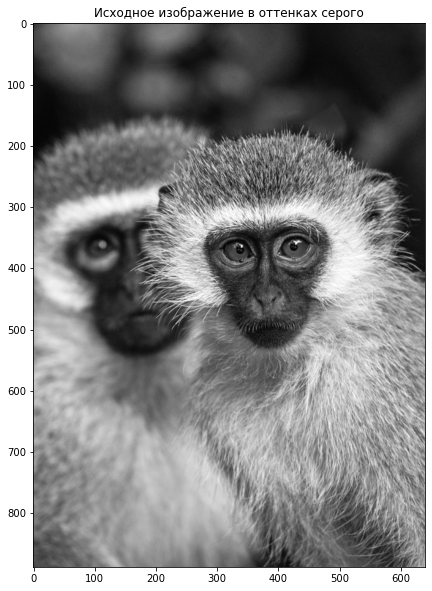

In [3]:
plt.figure(figsize=(10,10))
img = cv.imread(path_to_img, 0)
plt.title("Исходное изображение в оттенках серого")
plt.imshow(img, plt.cm.gray)

In [4]:
def hist(img:np.ndarray):
    plt.figure()
    plt.hist(img.ravel(), bins=255, color='gray')
    plt.title("histogram distributed pixels")
    plt.xlabel("grayscale value")
    plt.ylabel("pixel")
    plt.show()

In [9]:
@njit(parallel=True)
def gradient(img: np.ndarray, approximate: bool)->np.ndarray:
    x, y = img.shape
    output = np.zeros((x,y), np.uint8)
    for i in prange(1, x):
        for j in prange(1, y):
            s1 = img[i][j]-img[i-1][j]
            s2 = img[i][j]-img[i][j-1]
            if approximate:
                output[i][j]=math.fabs(s1)+math.fabs(s2)
            else:
                output[i][j] = math.hypot(s1,s2)
    return output

def threshold_processing(img: np.ndarray, threshold: np.uint8)->np.ndarray:
    output = np.where(img > threshold, 255, 0)
    return output

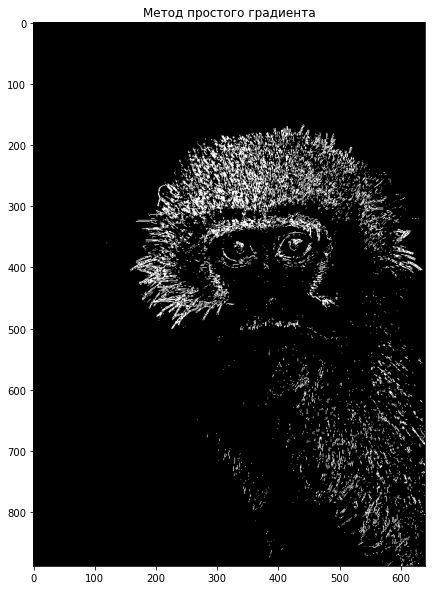

CPU times: user 335 ms, sys: 12.6 ms, total: 348 ms
Wall time: 328 ms


In [11]:
%%time
plt.figure(figsize=(10,10))
img_grad = threshold_processing(gradient(img, False), 40) # 40 for 1 monkey, 5 for two monkey 
plt.imshow(img_grad, cmap=plt.cm.gray)
plt.title("Метод простого градиента")
plt.show()

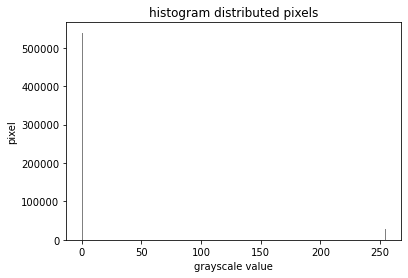

In [13]:
hist(img_grad)

In [16]:
def convolve(img:np.ndarray, struct:np.ndarray)->np.ndarray:
    img_x, img_y = img.shape
    struct_x, struct_y = struct.shape
    center_x = int(np.ceil(struct_x/2)-1)
    center_y = int(np.ceil(struct_y/2)-1)
    temp = np.zeros((img_x+2*center_x, img_y+2*center_y), dtype=np.uint8)
    temp[center_x:img_x+center_x,center_y:img_y+center_y] = img

    for i in range(struct_x):
        temp[i,:]=temp[center_x,:]
        temp[img_x+1+i:] = temp[img_y:]
    
    for i in range(struct_y):
        temp[:,i]=temp[:,center_y]
        temp[:,img_y+1+i]=temp[:,img_y]

    output = np.zeros((img_x+center_x, img_y+center_y), dtype=np.uint8)

    for i in range(center_x, img_x+center_x):
        for j in range(center_y, img_y+center_y):
            output[i-center_x, j-center_y]=np.sum(temp[i-center_x:i-center_x+1,j-center_y:j-center_y+1]*struct)
    return output     

In [17]:
struct =1 / 35 * np.array(
      [[ 4.,  1.,  0.,  1.,  4.],
       [ 1., -2., -3., -2.,  1.],
       [ 0., -3., -4., -3.,  0.],
       [ 1., -2., -3., -2.,  1.],
       [ 4.,  1.,  0.,  1.,  4.]]
  )

In [18]:
%%time
convolve_result = convolve(img, struct)
edges = threshold_processing(img, 1)
plt.figimage(edges)

ValueError: could not broadcast input array from shape (252,644) into shape (3,644)